# **<center>Improved AFM Simulation Code</center>**


<center>Authors: B. McKiernan, S. Hatzopoulos, W. Capp, A. Zhikharev</center>


To run the code for general use simply click the play button in the small box next to `41 cells hidden` in the code framework subsection. This will set up all the functions so that you can easily produce AFM image simulations using the GUI in section 2. This should take around 45-60s.

The GUI gives you the option to change all the variables in the final simulation function. Once you have selected your desired variables, hit shift+enter on your keyboard to run!

To debug the functions or cells, simply click the drop down arrows next to subsections. To access the code behind the GUI, or hide it, double click anywhere on the interface.

For details on AI based Object identification for AFM imaging artefacts please email willcapp09@gmail.com. I will do my best to give you a detailed explanation of the work I have completed so far and how to implement it yourself.

# 1.0 The Framework of the code

## 1.1.0 Importing Modules and Stuff


In [ ]:
%%capture
import sys
!{sys.executable} -m pip install py3Dmol
!pip install nglview
!pip install biopython
!pip install line_profiler

In [ ]:
from google.colab import output
output.enable_custom_widget_manager()

# Importing relevant modules
%matplotlib inline
import numpy as np     
from numpy import array,sqrt,tan,pi
import numexpr as ne
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
plt.rcParams["figure.figsize"] = (12,9)
plt.rcParams['figure.dpi'] = 256
import pandas as pd
from IPython.display import Image # For displaying images in Markdown
import pandas as pd ### might need to use this later
from mpl_toolkits.mplot3d import axes3d
import nglview as nv
import py3Dmol
import os
import tkinter as tk
from tkinter import *
import time
from random import randrange
import math
from tqdm.notebook import tqdm_notebook

# Deep Learning
# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras

### PDB stuff:
from Bio.PDB import * ### From video: youtube.com/watch?v=mL8NPpRxgJA&ab_channel=CarlosG.Oliver
pdbl = PDBList()
parser = MMCIFParser()
from Bio.PDB.PDBParser import PDBParser
pdb_parser = PDBParser(PERMISSIVE=1)
from Bio.PDB import Entity
from numpy import random

### Optimization 
import numba
from numba import prange

In [ ]:
import cProfile, pstats, io

def profile(fnc):
    
    """A decorator that uses cProfile to profile a function"""
    
    def inner(*args, **kwargs):
        
        pr = cProfile.Profile()
        pr.enable()
        retval = fnc(*args, **kwargs)
        pr.disable()
        s = io.StringIO()
        sortby = 'cumulative'
        ps = pstats.Stats(pr, stream=s).sort_stats(sortby)
        ps.print_stats()
        print(s.getvalue())
        return retval

    return inner

## 1.2.0 Defining Functions for the AFM simulator






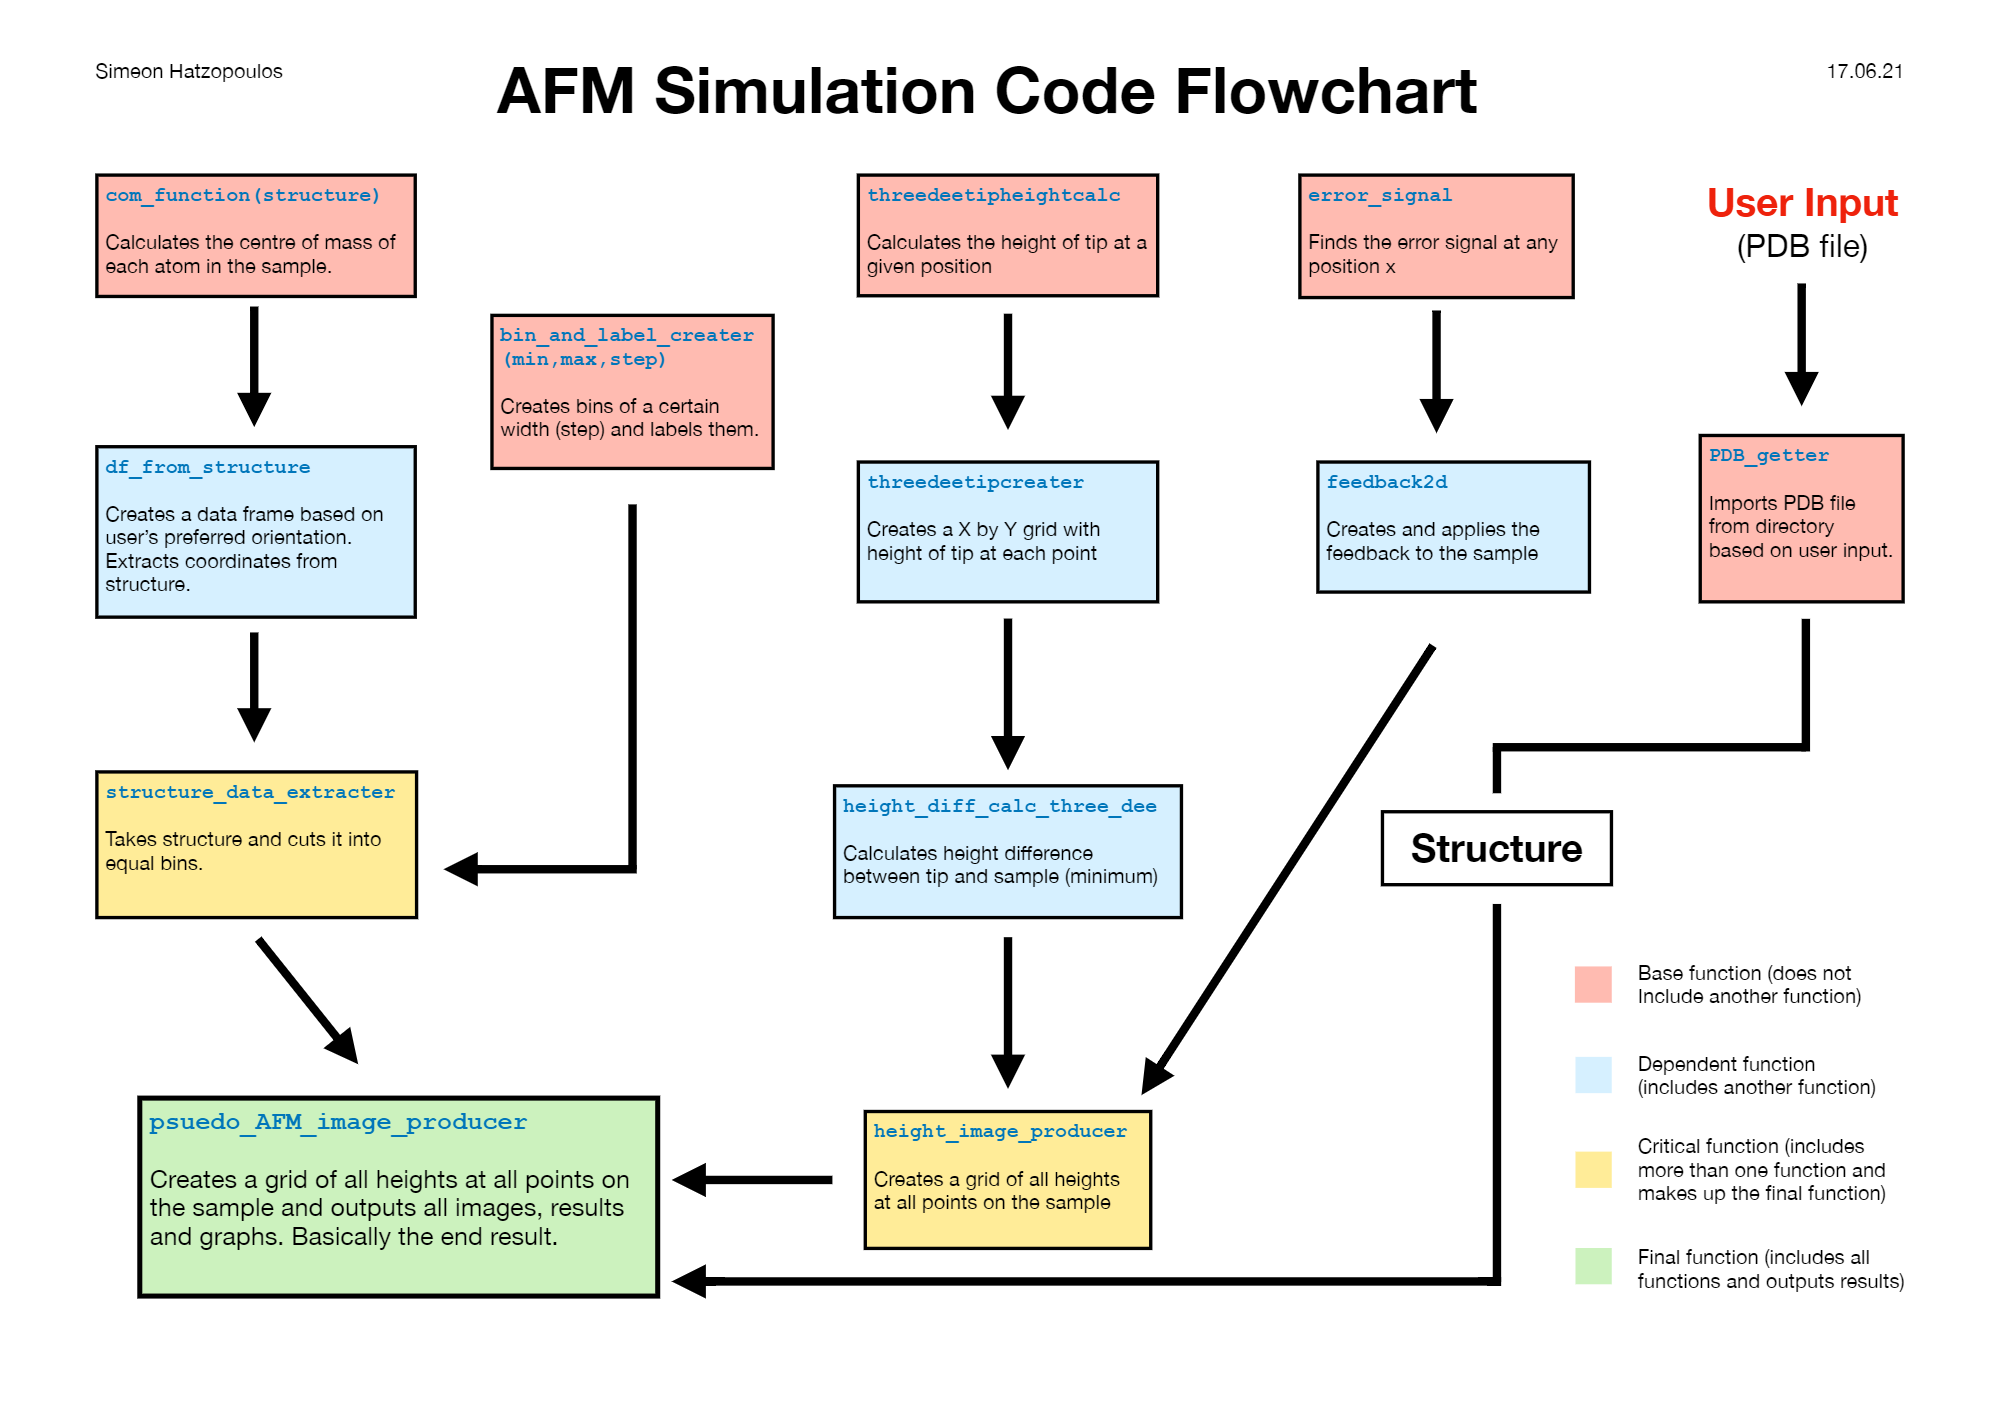


### 1.2.1 The Base Functions

We start the notebook by defining the base functions, shown in the red text boxes in the flowchart image above:

1.   `PDB_getter`
2.   `com_function`
3.   `bins_and_labels`
4.   `tipheight3D`
5.   `error_signal`

The first function we introduce is `PDB_getter`, which is used to import the pdb file for the proteins or biomolecules we wish to simulate an AFM image for.



### 1.2.1.1 `PDB_getter`

In [ ]:
### Function to get structure from pdb file 4 digit code
def PDB_getter(pdbid):
    '''
    This function imports the relevant PDB file (and takes care of the 
    directory) in which it is saved etc for the user, returning the structure 
    and the view using a widget.
        Params:
            pdbid - PDB (or CSV) file name of desired biomolecule
        Returns:
            Structure - of proteins (Atom coords/positions and masses etc...)
            View - for visualising the protein
    '''

    # Retrieves PDB file from 4 letter code using Bio.python
    pdbl.retrieve_pdb_file(pdbid)
    
    ### Creating a folder on the Users system 
    # Location is the same as the Notebook file's
    split_pdbid = list(pdbid)
    structure_file_folder = str(split_pdbid[1]) + str(split_pdbid[2])
    c ='.cif' # filetype prefix.
    the_slashes = '/' 
    # Set `the_slashes` as '/' for MAC and Google Colab
    # Or '//' for Windows
    d = 'pdb:' 
    directory = str(os.getcwd())
    
    # Retrieving file from the location it is saved in
    file_loc = directory + the_slashes + structure_file_folder + the_slashes + pdbid + c
    structure = parser.get_structure(pdbid, file_loc)  # Defining structure i.e. '4 letter PDB ID code' and 'location'
    viewer_name = d + pdbid
    
    # Plotting relevant structure using py3Dmol 
    view = py3Dmol.view(query=viewer_name).setStyle({'cartoon':{'color':'spectrum'}})
    
    return(structure,view)

### 1.2.1.2 `com_function`

In [ ]:
### Parallelised function to find centre of mass for atoms
def com_function(structure):
    ''' 
    Takes the biomolecular structure from the pdb files and returns
    centre of mass of each atom in the protein
        Params:
            Structure - (atoms, masses and positions) from PDB file or CSV file
        Returns:
            COM coordinates of each atom for image height calculations and
            general imaging
    '''
    
    # Retrieve and unpack atoms from structure input
    atom_list = structure.get_atoms()

    masses_array = []
    # Empty array of atom masses
    positions_array = atom_pos_array = [ [], [], [] ] # *2 seperate variables*
    # Empty array of positions  
    # Empty array of individual atom positions in format: [x], [y], [z]
    
    for atom in atom_list: # Loop for each atom
        masses_array.append(atom.mass) 
        # Creates array of all atoms masses in atom_list
        
        for i, coord in enumerate(atom.coord.tolist()): # Lists atom coords and designates them a count i
            positions_array[i].append(coord) 
            # Creates an array of atom coordinates 

        # Assigning a mass to each position (all directions accounted for)
    for atom_index, atom_mass in enumerate(masses_array):
        atom_pos_array[0].append(positions_array[0][atom_index]*atom_mass) #x coordinates 
        atom_pos_array[1].append(positions_array[1][atom_index]*atom_mass) #y coordinates
        atom_pos_array[2].append(positions_array[2][atom_index]*atom_mass) #z coordinates
    
    return [sum(coord_list)/sum(masses_array) for coord_list in atom_pos_array]  

### 1.2.1.3 `bins_and_labels`


In [ ]:
### Function to define bins and labels
def bins_and_labels(min,max,w):
    '''
    Creates bins of chosen width with respective labels
        Params:
            min - minimum value or start of sample
            max -  maximum value or end of sample
            w - desired bin width
        Returns:
            bins - array of binned coordinate data for specified widths w
            labels
    '''
    # Creating bins between min and max with width w 
    # Creating labels in centre of each bin created
    bins,labels = np.arange(min,max+w,w),np.arange(min+(w/2),max+(w/2),w)

    return bins,labels

### 1.2.1.4 `tipheight3D`


In [ ]:
### Finds height of tip in 3D
@numba.njit
def tipheight3D(x,y,x_tip,y_tip,theta_degrees,r):
    '''
    Calculates and returns magnitude of tip height
        Params:
            x - x coordinate for tip height to be found
            y - y coordinate for tip height to be found at
            x_tip - x position for centre of tip
            y_tip - y coord for centre of tip
            theta_degrees - Angle in degrees
            r - Radius of tip (assuming spherical tip)
        Returns:
            z - height of tip centre at desired x,y coord / Angstroms (x10-10 m)
    '''
    # Converting theta from degrees to radians 
    theta = theta_degrees*(pi/180)
   
    # Finding gradient based on figure 6 in report
    alpha = 1/(tan(theta))   # `aplha` == gradient

    # Creating delta parameter from figure 6
    # i.e. distance between tip and tangent point 
    grad_del = ( sqrt( abs( (r*alpha)**2 / (1+alpha**2) )))
    
    # Tangent point (where cone meets sphere)
    X = x_tip + grad_del
    y_int = (-sqrt(r**2 - grad_del**2) + r - alpha*(grad_del)) 
    # Finding y intercept - see report 
    dist_from_centre = (((x-x_tip)**2 + (y - y_tip)**2)) 
    # Distance from the centre of tip
    
    z0 = y_int # should always be equal
    
    ### Constructing conical and spherical parts boundaries of tip
    # Spherical Boundary
    if dist_from_centre < grad_del**2: 
        z = (-sqrt(r**2 -(x-x_tip)**2 - (y-y_tip)**2) + r)
    
    # Conical Boundary
    else: 
        c = tan(theta) # not equal to 1/tan(theta) bc theta is defined as angle between vertical not horizontal
        z = (sqrt((((x-x_tip)**2 + (y-y_tip)**2)/(c**2))) + z0)
        # Final tip height calculation for given X and Y coords
    
    return(z)

### 1.2.1.5 `error_signal`



In [ ]:
### Finds error signal for mechanism feedback
@numba.njit
def error_signal(x,setpoint,arb,n,grad): 
    '''
    Calculates error signal for feedback mechanism based on the differential
    between setpoint height and probe height
        Params:
            x - position
            setpoint - start height for tip
            arb - arbitrary number after which the 
                    feedback mechanism doesn't increase 
            grad - gradient of error graph (see report)
        Returns:
            error_value
    '''
    # Creating linear error graph up to a point where the error stays constant 
    # Meaning no effect on tip
    if x > (setpoint+arb):
        return -grad*(arb)  
        # Linear relationship when z is below the setpoint 
        
    else :
        return -grad*(x-setpoint) 
        # No effect (horizontal line) when z is above the setpoint 

### 1.2.1.6 Thermal Drift Central Atom

In [ ]:
def arrayiszero(array):
    '''
    Finds the array index value where the array value is zero
    Used to plot the thermal drift of images
        Params:
            Array - array to find central atom (atom at origin)
        Returns:
            Index - Index of origin of atom
    '''

    for i,k in enumerate(array):
        
        if math.isclose(k,0,abs_tol = 0.5) == True:
            
            return i 

    return i//2

### 1.2.2 Secondary Functions

With the base functions defined we can introduce the secondary functions that build upon the foundations:

1.   `df_from_structure`
2.   `tipcreator3D`
3.   `heightdiff3D`
4.   `feedback2D`

---

### 1.2.2.1 `df_from_structure`


In [ ]:
### Extracting a data frame from the biomolecule structure
### Currently the df dataframe is not registering most of the coordinate positions o
def df_from_structure(structure,x_rot,y_rot,z_rot,view_style):
    '''
    This function  produces a dataframe with the XYZ coordinates of each
    atom and automatically adjust the Z values so the minimum Z value equals 
    zero    
        Params:
            structure - input recieved from PDB/CSV file (atom list, masses, positions)
            x_rot - Desired rotation in x plane (horizontal) / degrees
            y_rot - Desired rotation in y plane (horizontal) / degrees
            z_rot - Desired rotation in z plane (vertical) / degrees
            view_style - Style for molecule to be viewed in
        Returns:
            df - Data frame for molecular structure input
            sample_max_height - Maximum height for molecule
            post_adj_view - View adjusted for desired plane rotations
    '''
    
    
    # Creating rotation matrices according to user input 
    null_rotation_matrix = rotaxis2m(0, Vector(0,0,1))  #BioPython command to rotate around axis m
    rotation_matrix = rotaxis2m(x_rot*(np.pi/180), Vector(1,0,0)) 
    rotation_matrix_2 = rotaxis2m(z_rot*(np.pi/180), Vector(0,0,1))
    rotation_matrix_3 = rotaxis2m(y_rot*(np.pi/180), Vector(0,1,0))
    # Angles converted to radians within `rotaxis2m` function
    
    if len(structure) == 1: 
        # Retrieving atoms, COM and position
        atoms = structure.get_atoms() 
        #BioPython: structure.get --> position of atoms

        #print(atoms) #for checking the outputs 


        com = com_function(structure) # Find COM using previous function
        mean_x, mean_y, mean_z = com[0],com[1],com[2] 
        # Positions from COM

        ###### Not quite sure ######
        translation_matrix = array((0, 0, 0), 'f')
        true_translation_matrix = array((-mean_x, -mean_y, -mean_z), 'f')  

        # Empty arrays for each cartesian coordinate
        x_coord_array=[]
        y_coord_array=[]
        z_coord_array=[]

        # Transforming protein to user's preferred orientation
        for atom in atoms:
            atom.transform(null_rotation_matrix, true_translation_matrix)  
            # Applies matrices to each atom 
            atom.transform(rotation_matrix,translation_matrix) 
            atom.transform(rotation_matrix_2, translation_matrix)
            atom.transform(rotation_matrix_3, translation_matrix)

            x = atom.get_coord()[0]  # Returns atomic coordinates for x
            y = atom.get_coord()[1]  # Returns atomic coordinates for y
            z = atom.get_coord()[2]  # Returns atomic coordinates for z

            # New set of coordnates for User's orientation
            x_coord_array.append(-x) 
            y_coord_array.append(-y)
            z_coord_array.append(-z)

        # Transposing the tip (either up or down) according to min displacement
        z_min = np.min(z_coord_array) 
        # Min displacement between tip and sample
        z_adjust_array = (-z_min)*np.ones(len(z_coord_array)) 
        # Creates an array with only -z terms 
        final_z_coord_array = np.add(z_coord_array,z_adjust_array) 
        # z_adjust_array subtracted from z to shift the tip down

        sample_height_max = np.max(final_z_coord_array) #why max?

        # Creating a dataframe for x y and z coordinates (in one set)
        d = {'X': x_coord_array, 'Y': y_coord_array, 'Z': final_z_coord_array} 
        df = pd.DataFrame(data=d) # Produces correct data frame

        ### Viewing the protein
        post_adj_view = nv.show_biopython(structure)
        post_adj_view.add_representation(view_style, selection='protein')

        ### Returning Structure to original rotation 
        # If confused query original authoer via email: brendan.mckiernan.17@ucl.ac.uk)
        atoms = structure.get_atoms()
        com = com_function(structure)
        mean_x, mean_y, mean_z = com[0],com[1],com[2]

        # Resets protein to orignal position
        # Allowing user to enter a different orientation
        null_rotation_matrix = rotaxis2m(0, Vector(0,0,1))
        rotation_matrix = rotaxis2m(-x_rot*(np.pi/180), Vector(1,0,0)) #opposite to matrices above
        rotation_matrix_2 = rotaxis2m(-z_rot*(np.pi/180), Vector(0,0,1)) #resets previous rotations
        rotation_matrix_3 = rotaxis2m(-y_rot*(np.pi/180), Vector(0,1,0))
        translation_matrix = array((0, 0, 0), 'f')
        true_translation_matrix = array((-mean_x, -mean_y, -mean_z), 'f')  

        for atom in atoms:
            atom.transform(rotation_matrix_3,translation_matrix)
            atom.transform(rotation_matrix_2, translation_matrix)
            atom.transform(rotation_matrix, translation_matrix)
        

    elif type(structure) is tuple:
    # User must input x, y and z coordinate arrays  
        # Unpacking arrays
        x1 = structure[0]
        y1 = structure[1]
        z1 = structure[2]
        
        # Flattening 
        x_flat = x1.flatten()
        y_flat = y1.flatten()
        z_flat = z1.flatten()

        # Transposing the tip (either up or down) according to the min displacement
        z_min = np.min(z_flat) # Finding min displacement between tip and sample
        z_adjust_array = (-z_min)*np.ones(len(z_flat)) 
        # Creates an array with only -z terms 
        final_z_flat = np.add(z_flat,z_adjust_array) 
        # final_z_flat array subtracted from z_flat to shift the tip down

        sample_height_max = np.max(final_z_flat) #why max?
                                   
        d = {'X': x_flat, 'Y': y_flat, 'Z': final_z_flat} 
        df = pd.DataFrame(data=d) # Produces correct data frame
        
        post_adj_view = 0 
        #post_adj_view = ax.plot_surface(x1, y1, z1, cmap=plt.cm.YlGnBu_r)
        #post_adj_view.add_representation(view_style, selection='protein')
        
        #print(df)
        
    else:
        
        #Data1 = pd.read_csv('Data_array.csv', index_col=False)
        
        x1, y1, z1 = structure.T.values
        
        # Flattening 
        x_flat = x1.flatten()
        y_flat = y1.flatten()
        z_flat = z1.flatten()

         # Transposing the tip (either up or down) according to the min displacement
        z_min = np.min(z_flat) # Finding min displacement between tip and sample
        z_adjust_array = (-z_min)*np.ones(len(z_flat)) 
        # Creates an array with only -z terms 
        final_z_flat = np.add(z_flat,z_adjust_array) 
        # final_z_flat subtracted from z to shift the tip down

        sample_height_max = np.max(final_z_flat) #why max?
                                   
        d = {'X': x_flat, 'Y': y_flat, 'Z': final_z_flat} 
        df = pd.DataFrame(data=d) # Produces correct data frame
        
        post_adj_view = 0
        #post_adj_view = ax.plot_surface(x1, y1, final_z_flat, cmap=plt.cm.YlGnBu_r)
        #post_adj_view.add_representation(view_style, selection='protein')
    
    return(df, sample_height_max, post_adj_view)

### 1.2.2.2 `tipcreator3D`

In [ ]:
### JIT compiled function that creates an array for tip heights across Image Grid
@numba.njit
def tipcreator3D(X,Y,x_tip,y_tip,theta_degrees,r):
    '''
    This function creates an array representing the height of the tip across all
    X and Y coordinates 
        Params:
            X - x range along which the array runs
            Y - y range along which the array runs
            x_tip - x position for centre of tip
            y_tip - y position for centre of tip
            theta_degrees - Angle of tip surface in degrees
            r - Radius of spherical tip
        Returns:
            Z - All heights across X by Y grid
    
    
    Find a way to run function without calling tipcreator3D and tipcreatorbinned every time
    '''
    
    # creating an array of all heights Z
    Z = []  
    
    # Loop through range of all x and y values and combinations
    for n in range(len(Y)):  
        Z_sub_array=[]
        for i in range(len(X)):
            Z_sub_array_element = tipheight3D(X[i],Y[n],x_tip,y_tip,theta_degrees,r)
            Z_sub_array.append(Z_sub_array_element)
        Z.append(Z_sub_array) 
        # Final array of heights across the grid
    
    return array(Z) #return all heights across X by Y grid

### 1.2.2.3 `tipcreatorbinned`

In [ ]:
### JIT compiled function that creates an array for tip heights across Image Grid
@numba.njit
def tipcreatorbinned(Xlabels,Ylabels,reduced_sorted_bdf_filled):
    '''
    This function creates an array representing the height of the tip across all
    binned coordinates
        Params:
            Xlabels - Labels for x coord data created by `structure_data_extracter`
            Ylabels - Labels for y coord data created by `structure_data_extracter`
            reduced_sorted_bdf_filled - the binned date frame
        Returns:
            Z - All heights across X by Y grid
    
    
    Find a way to run function without calling tipcreator3D and tipcreatorbinned every time
    '''
    Ylen = len(Ylabels)
    Z = [] # Empty height array

    # Loop through range of all Xlabels and Ylabels values and combinations
    for n in range(Ylen):  
        Z_sub_array=[]  
        for i in range(len(Xlabels)):  
            Z_sub_array_element = reduced_sorted_bdf_filled[i*Ylen+n]
            Z_sub_array.append(Z_sub_array_element)  
        Z.append(Z_sub_array)  
        # Creating an array for heights Z in binned data  
    
    return array(Z)  

### 1.2.2.4 `heightdiff3D`

In [ ]:
### Calculates Final Corrected Image heights for each coordinate position in the grid
@numba.njit
def heightdiff3D(Xlabels,Ylabels,reduced_sorted_bdf_filled,x_tip,y_tip,theta_degrees,r):
    '''
    This function calculates the adjustment to the height of the tip, based on the tip's steric
    interaction with the structure. 
        Params:
            Xlabels - Labels for x coord data created by `structure_data_extracter`
            Ylabels - Labels for y coord data created by `structure_data_extracter`
            reduced_sorted_bdf_filled - the binned date frame
            x_tip - x position for centre of tip
            y_tip - y position for centre of tip
            theta_in_degree - Angle of tip surface in degrees
            r - Radius of spherical tip
        Returns:
            corrected_height_data - New tip height dependent on particular data frame
    '''

    # Creating heights from binned data frame 
    Z_binned = tipcreatorbinned(Xlabels,Ylabels,reduced_sorted_bdf_filled)
       
    # Creating tip for binned data frame 
    Z_tip = tipcreator3D(Xlabels,Ylabels,x_tip,y_tip,theta_degrees,r)
    
    # Finding displacement of tip and correcting it (AFM measuring)
    # Adjusted 
    height_delta = (Z_tip - Z_binned) # Difference between atom data and tip heights
    min_delta = np.min(height_delta) # Finding mim difference in heights
    corrected_height_delta = (-1)*min_delta # Subtracting minimum difference 
    
    return(corrected_height_delta) #returns the new height of tip

### 1.2.2.5 `feedback2D`

In [ ]:
@numba.njit
def mean_numba(a):

    sum = 0
    for i in a:
        sum += i

    return sum / len(a)

In [ ]:
### Function to produce feedback for AFM image
@numba.njit
def feedback2D(scanline,setpoint,arb,KP_eff,KI,n,grad):
    '''
    Applies the feedback mechanism to a scanline and calculates the error 
    signal at each point. Feedback strength is based on the values of KP & KI.
        Params:
            Scanline - Array of position coordinates to be scanned
            setpoint - Height which tip begins at
            KP_eff - 
            KI - 
            grad - gradient of error graph
        Returns:
            feedbacked_image - New coordinates for scanline
    '''
    
    # Initial conditions for while loop and scanline
    feedbacked_image = [scanline[0]]
    delta_height_array = [] # Height of probe empty array
    error_array = [] # Empty error array
    
    
    for i in range(len(scanline)-1):
        
        # For each point a difference in the height of the tip and the sample (scanline) is found 
        # this difference is tells the feedback mechanism to move the tip up or down 
        
        delta_height = (feedbacked_image[i] - scanline[i]) # Difference between probe and scanline height
        delta_height_array.append(delta_height) # Added to height array
        
        # Creating error curve for each point 
        error = error_signal(delta_height,setpoint,arb,n,grad)
        error_array.append(error)
        
        # Calculating the feedback
        feedback = KP_eff * error + KI * mean_numba(error_array) 
        feedbacked_image.append(feedbacked_image[i] + feedback) 
        # Feedback added to scanline
    
    
    return array(feedbacked_image)

In [ ]:
# Illustration of error signal, displacement relationship - TEST CELL

#setting conditions - TEST
arb_trial = 5
setpoint_trial = 0
power = 1
grad = 3

#creating array of plotted values 
feedback_values = []

#creating an error signal to plot 
n = -30
i = n
while i <= (-n):
    feedback_val = error_signal(i,setpoint_trial,arb_trial,power,grad)
    feedback_values.append(feedback_val)
    i = i + 1
    
#Plotting figure 
fig, ax = plt.subplots()
ax.plot(np.arange(n,-(n-1),1),feedback_values,'-')
ax.grid(True, which='both')
ax.axhline(y=0, color='k')
ax.axvline(x=0, color='k')
plt.show();

### 1.2.3 Tertiary Functions

Following on we can introduce our tertiary functions that rely on at least two strings of secondary and base functions:



1.   `structure_data_extracter`
2.   `height_image_producer`



---


### 1.2.3.1 `structure_data_extracter`

In [ ]:
##### Making a function for taking structure, zeroing and putting into a binned dataframe
def structure_data_extracter(structure,xstep,ystep,extension,x_rot,y_rot,z_rot,view_style):
    '''
    This function takes the initial structure and cuts it into a binned dataframe
        Params:
            structue - of PDB/CSV file 
            xstep - bin width of each bin for x coords (Angstroms)
            ystep - bin width of each bin for y coords (Angstroms)
            extension - Size of the stage on which the protein sits
                        How far to extend image plots for AFM image (Angstroms)
            x_rot - Desired rotation in x plane (horizontal) / degrees
            y_rot - Desired rotation in y plane (horizontal) / degrees
            z_rot - Desired rotation in z plane (vertical) / degrees
            view_style - Style for molecule to be viewed in
        Returns:
            Xlabels - Labels for x coord data created by `structure_data_extracter`
            Ylabels - Labels for y coord data created by `structure_data_extracter`
            reduced_sorted_bdf_filled - the binned date frame (Array format)
            new_df - New binned data frame for molecular structure input
            sample_max_height - Maximum height for molecule
            post_adj_view - View adjusted for desired plane rotations
    '''
    
    new_df, sample_height_max, post_adj_view = df_from_structure(structure,x_rot,y_rot,z_rot,view_style) 
    
    # Find max and min for x and y in new data frame
    Y_max, Y_min = new_df['Y'].max(), new_df['Y'].min()
    X_max, X_min = new_df['X'].max(), new_df['X'].min()
    
    # Create bins and respective labels
    Xbins, Xlabels = bins_and_labels(X_min-extension,X_max+extension,xstep)
    Ybins, Ylabels = bins_and_labels(Y_min-extension,Y_max+extension,ystep)
    
    # pd.cut takes a continuous data set and cuts and sorts it into bins:
    new_df['Binned_Y'] = pd.cut(new_df['Y'], Ybins, right = False, labels = Ylabels) 
    new_df['Binned_X'] = pd.cut(new_df['X'], Xbins, right = False, labels = Xlabels)
    
    sorted_bdf = new_df.sort_values('Binned_X') # Sorting bins for X

    # Zeroing data and dropping unwanted X and Y values - only height needed 
    reduced_col_bdf = sorted_bdf.drop(columns = ['X','Y'])
    reduced_sorted_bdf = reduced_col_bdf.groupby(['Binned_X','Binned_Y'])['Z'].max() # Max z values 
    reduced_sorted_bdf_filled = reduced_sorted_bdf.replace(np.nan, 0.0) 
    # nan - 'not a number' replaced with 0
    
    return(array(reduced_sorted_bdf_filled),Xlabels,Ylabels,new_df,sample_height_max,post_adj_view)

### 1.2.3.2 `height_image_producer`

In [ ]:
### Figure out how to work with NUMBA (last function to get to work then will speed up fast)

def height_image_producer(Xlabels,Ylabels,reduced_sorted_bdf_filled,theta_degrees,r,noise_strength,
                          noise_mean,noise_variance,setpoint,arb,KP_eff,KI,n,grad,scanline_direction,
                          Feedbacked,ThermalDrift,ScanRate,DriftRate,DriftAngle):
    '''
    Produces an array representing height of the sample across all x and y.
        Params:
            Xlabels - Labels for x coord data created by `structure_data_extracter`
            Ylabels - Labels for y coord data created by `structure_data_extracter`
            reduced_sorted_bdf_filled - the binned date frame
            theta_in_degree - Angle of tip surface in degrees
            r - Radius of spherical tip
            noise_strength -
            noise_mean -
            noise_variance - 
            setpoint - initial height of tip
            KP_eff -
            KI - feedback coefficients
            grad - gradient of error graph (see report)
            scanline_direction - Direction to scan in AFM image (Right/Left/Both)
            Feedbacked - Boolian / True or False
        Returns:
            H_array - Height based on steric collision model (with noise)
            H2 - Height based on feedbback mechanism
            '''

    # Initialising empty arrays
    H= [] # Initial array for steric collision model
    H2=[] # Initial array for feedback mechanism


    if ThermalDrift == True:

        if DriftAngle == 361:
            DriftAngle = randrange(0,360,1)

        DriftAngle = DriftAngle * (np.pi/180)

        Y_drift = DriftRate * np.sin(DriftAngle)
        X_drift = DriftRate * np.cos(DriftAngle)

    else:
        X_drift = Y_drift = 0
    
    # Creating a grid 
    for n in range(len(Ylabels)):
        H_sub_array= np.zeros(len(Xlabels))  
        # Each H_sub_array is effectively a scanline at a given value of Y
        
        for i in range(len(Xlabels)):
            
            # Calculating height diff
            H_sub_array_element = heightdiff3D(Xlabels,Ylabels,reduced_sorted_bdf_filled,Xlabels[i],Ylabels[n],theta_degrees,r)
            H_sub_array[i] = H_sub_array_element            
        
                # Adding in noise to each scanline
        noise_array = new_noise_array = np.zeros(len(H_sub_array))
        for k in range(len(H_sub_array)):
            noise_array[k] = noise_strength*random.normal(noise_mean,noise_variance)  #Gaussian
            new_noise_array[k] = noise_strength*random.normal(noise_mean,noise_variance)  #Gaussian

        H_sub_array_with_noise = H_sub_array + noise_array

        ### Now considering scanning Right to Left
        
        # Different noise on second scan back
        reverse_H_sub_array = H_sub_array[::-1] # New array reversed but code stays the same
        reverse_H_sub_array_with_noise = reverse_H_sub_array + new_noise_array
        
        if Feedbacked == True:
        
            # Adding in Feedback to each scanline
            H_sub_array_with_noise_and_feedback = feedback2D(H_sub_array_with_noise,setpoint,arb,KP_eff,KI,n,grad)
            reverse_scanline_H_sub_array = feedback2D(reverse_H_sub_array_with_noise,setpoint,arb,KP_eff,KI,n,grad)[::-1]

        else:
            H_sub_array_with_noise_and_feedback = 0.0
            reverse_scanline_H_sub_array = 0.0

        ### Merging both feedback lines:
        H_sub_array_both_directions = (1/2)*(H_sub_array_with_noise_and_feedback + reverse_scanline_H_sub_array)     

            
        ### Merging both scanlines with noise:
        H_sub_array_with_noise_both_directions = (1/2)*(H_sub_array_with_noise + reverse_H_sub_array_with_noise)
        H.append(H_sub_array_with_noise)
        
        # Assigning arrays to an appropriate designation
        if scanline_direction == 'Left to right':
            H2.append(H_sub_array_with_noise_and_feedback)
                        
        if scanline_direction == 'Right to left':
            H2.append(reverse_scanline_H_sub_array)
                    
        if scanline_direction == 'Both':
            H2.append(H_sub_array_both_directions)
        
        if Feedbacked and ThermalDrift == True:
            if n % ScanRate == 0:
                Xlabels[n:] += X_drift
                Ylabels[n:] += Y_drift
        
        else:
            continue


    H_array = array(H) # Height based on steric collision model
    H2 = array(H2) # Height based on feedback mechanism 
    
    return H_array, H2, X_drift, Y_drift, DriftAngle, Xlabels, Ylabels

### 1.2.4 The Final Function

We can now bring all our prior functions together into one final function `AFM_sim_image_producer`



In [ ]:
import matplotlib.patches as mpatches

rect1 = mpatches.Rectangle((-28,-25),42,20,fill=True,color='Red',alpha=0.25)
rect2 = mpatches.Rectangle((-28,-5),42,30,fill=True,color='Green',alpha=0.25)

In [ ]:

# Profile class for benchmarking and timing individual functions within the
# Final image producing function
def AFM_sim_image_producer(structure, r, theta_degrees, xstep, ystep, extension, x_rot, y_rot, z_rot, 
                            noise_strength,noise_mean,noise_variance,setpoint,arb,KP_eff,KI,n,grad,
                            scanline_direction,ScanRate,DriftRate,DriftAngle,ThreeDplot,
                            Feedbacked,ThermalDrift, Heatmap,Sharp_Color_Map,ImageBank,
                            Colmap,molecule_view, view_style,Simulated_Surface,DotPlot,Overlay_Plot,
                            relative_contrast,feedback_graph,StructureName,GoogleDrive):
    '''
    Final function which brings everything together. User inputs all variables and all results 
    are outputted. The user gets a feedback plot of the error values, A heatmap of the AFM image,
    and 3D plots of the sample surface.
        Params:
            structure - input recieved from PDB/CSV file (atom list, masses, positions)
            r - Radius of spherical tip
            theta_in_degree - Angle of tip surface in degrees
            xstep - bin width of each bin for x coords (Angstroms)
            ystep - bin width of each bin for y coords (Angstroms)
            extension - Size of the stage on which the protein sits
                        How far to extend image plots for AFM image (Angstroms)
            x_rot - Desired rotation in x plane (horizontal) / degrees
            y_rot - Desired rotation in y plane (horizontal) / degrees
            z_rot - Desired rotation in z plane (vertical) / degrees
            noise_strength -
            noise_mean -
            noise_variance - 
            setpoint - initial height of tip
            arb - 
            KP_eff -
            KI - feedback coefficients
            n -
            grad - gradient of error graph (see report)
            scanline_direction - Direction to scan in AFM image (Right/Left/Both)
            ThreeDplot -
            Heatmap -
            Feedbacked - Boolian / True or False
            Sharp_Color_Map -
            Colmap -
            molecule_view - 
            view_style -
            Simulated_Surface -
            DotPlot -
            Overlay_Plot -
            relative_contrast -
            feedback_graph -
        Returns:
            Final simulated images for entire code
    '''
    
    # First data is extracted from PDB file using function
    structure_df_check,Xlabels,Ylabels,new_df,sample_height_max,post_adj_view = structure_data_extracter(structure,xstep,ystep,
                                                                                                         extension, x_rot,
                                                                                                         y_rot,z_rot, view_style)
    Drifttext = ''
    
    # Height of tip found for all points 
    Z_AFM, feedbacked_H, X_drift, Y_drift, FinalDriftAngle, Xlabels, Ylabels = height_image_producer(Xlabels,Ylabels,structure_df_check,theta_degrees,
                                                r,noise_strength,noise_mean,noise_variance,setpoint,
                                                arb,KP_eff,KI,n,grad,scanline_direction,Feedbacked,
                                                ThermalDrift,ScanRate,DriftRate,DriftAngle)
    
    if ThermalDrift==True:
        Xorig, Yorig = Xlabels, Ylabels
        Xmid, Ymid = arrayiszero(Xlabels), arrayiszero(Ylabels)

    ### Depending what the user needs - Heatmap with feedback and noise
    if Feedbacked == True:
        
        # Plotting AFM image with feedback + noise
        fig=plt.figure()
        #fig=plt.figure(figsize=(12,9),dpi=200)
        #fig.suptitle('AFM image w/feedback + noise', fontsize=16)
        x = Xlabels
        y = Ylabels
        X, Y = np.meshgrid(x, y)
        
                ### This section is for adjusting the contrast in colour map image ###
        feedbacked_H_range = feedbacked_H.max()-feedbacked_H.min()
        vmin_value = feedbacked_H_range * relative_contrast
        plt.contourf(X,Y,feedbacked_H,levels=100, cmap='afmhot', vmin = vmin_value) #creating contours
        plt.colorbar()
        ImgName = 'Name: ' + StructureName.upper() + '\nScan Direction: ' + scanline_direction + '\nRotations: (' +str(x_rot)+'$^{\circ}$,' + str(y_rot) +'$^{\circ}$,' + str(z_rot) + '$^{\circ}$)'
        plt.gcf().text(0.125,0.9,ImgName,color='Black',ha='left',fontsize=7)
        if ThermalDrift==True:
            DriftValues='Drift Angle = '+str(DriftAngle)+'$^{\circ}$\nX Drift = '+str(np.round(X_drift,3))+'\nY Drift = '+str(np.round(Y_drift,3))
            plt.gcf().text(0.745,0.9,DriftValues,color='Black',ha='right',fontsize=7)
            #plt.axvline(-5,color='green',alpha=0.7)
            #plt.axhline(-5,color='green',alpha=0.7)  
            #plt.axvline(X_drift*Xmid,color='dodgerblue',alpha=0.7)
            #plt.axhline(Y_drift*Ymid,color='dodgerblue',alpha=0.7)
            Drifttext = '_drift'

        if GoogleDrive == True:
            images_dir = '/content/gdrive/My Drive/AFMImages/Feedback'
            plt.savefig(f"{images_dir}/Feedback_{StructureName}_{x_rot}_{y_rot}_{z_rot}{Drifttext}.jpg", format ='jpg',transparent=True,pad_inches=2)
    
    ### A heatmap of the AFM image is a good visual tool, so it will be included 
    if Heatmap == True:
        
        #plotting heatmap without feedback
        fig = plt.figure()
        #fig.suptitle(' AFM image, no feedback ')      
        x = Xlabels
        y = Ylabels
        X, Y = np.meshgrid(x, y)
        
                ### This section is for adjusting the contrast in colour map image ###
        Z_AFM_range = Z_AFM.max()-Z_AFM.min()
        vmin_value = Z_AFM_range * relative_contrast
        plt.contourf(X,Y,Z_AFM,levels=100, cmap='afmhot', vmin = vmin_value) #creating contours - as above
        ImgName = 'Name: ' + StructureName.upper() + '\nScan Direction: ' + scanline_direction + '\nRotations: (' +str(x_rot) +'$^{\circ}$,' + str(y_rot) +'$^{\circ}$,' + str(z_rot) +'$^{\circ}$)'
        plt.gcf().text(0.125,0.9,ImgName,color='Black',ha='left',fontsize=7)
        plt.colorbar()       
        if ThermalDrift==True:
            DriftValues = 'Drift Angle = '+str(DriftAngle)+ '$^{\circ}$\nX Drift = ' + str(np.round(X_drift,3)) + '\nY Drift = ' + str(np.round(Y_drift,3))
            plt.gcf().text(0.745,0.9,DriftValues,color='Black',ha='right',fontsize=7)
            #plt.axvline(0,color='green',alpha=0.7)
            #plt.axhline(0,color='green',alpha=0.7)  
            #plt.axvline(X_drift*Xmid,color='dodgerblue',alpha=0.7)
            #plt.axhline(Y_drift*Ymid,color='dodgerblue',alpha=0.7) 
            Drifttext = '_drift'
        if GoogleDrive == True:
            images_dir = '/content/gdrive/My Drive/AFMImages/Heatmap'
            plt.savefig(f"{images_dir}/HeatMap_{StructureName}_{x_rot}_{y_rot}_{z_rot}{Drifttext}.jpg", format ='jpg',transparent=True,pad_inches=2)


    if Sharp_Color_Map == True:

        # Plotting AFM image with feedback + noise
        fig, axs = plt.subplots(2,2,figsize=(11.2,9))
        #fig.suptitle('AFM image w/feedback + noise', fontsize=16)
        x = Xlabels
        y = Ylabels
        X, Y = np.meshgrid(x, y)
        
        feedbacked_H_range = feedbacked_H.max()-feedbacked_H.min()
        vmin_value = feedbacked_H_range * relative_contrast
        FeedbackedNormal = axs[0,0].contourf(X,Y,feedbacked_H,levels=100, cmap='afmhot', vmin = vmin_value)
        divider = make_axes_locatable(axs[0,0])
        cax = divider.append_axes('right', size='5%', pad=0.05)
        fig.colorbar(FeedbackedNormal, cax=cax, orientation='vertical') 

        x = Xlabels
        y = Ylabels
        X, Y = np.meshgrid(x, y)
        Z_AFM_range = Z_AFM.max()-Z_AFM.min()
        vmin_value = Z_AFM_range * relative_contrast
        HeatMapNormal = axs[0,1].contourf(X,Y,Z_AFM,levels=100, cmap='afmhot', vmin = vmin_value)
        divider = make_axes_locatable(axs[0,1])
        cax = divider.append_axes('right', size='5%', pad=0.05)
        fig.colorbar(HeatMapNormal, cax=cax, orientation='vertical')  
        
        x = Xlabels
        y = Ylabels
        X, Y = np.meshgrid(x, y)
        feedbacked_H_range = feedbacked_H.max()-feedbacked_H.min()
        vmin_value = feedbacked_H_range * relative_contrast
        FeedbackedContour = axs[1,0].contourf(X,Y,feedbacked_H,levels=100, cmap=Colmap, vmin = vmin_value)
        divider = make_axes_locatable(axs[1,0])
        cax = divider.append_axes('right', size='5%', pad=0.05)
        fig.colorbar(FeedbackedContour, cax=cax, orientation='vertical')  
        
        x = Xlabels
        y = Ylabels
        X, Y = np.meshgrid(x, y)
        Z_AFM_range = Z_AFM.max()-Z_AFM.min()
        vmin_value = Z_AFM_range * relative_contrast
        HeatMapContour = axs[1,1].contourf(X,Y,Z_AFM,levels=100, cmap=Colmap, vmin = vmin_value)
        divider = make_axes_locatable(axs[1,1])
        cax = divider.append_axes('right', size='5%', pad=0.05)
        fig.colorbar(HeatMapContour, cax=cax, orientation='vertical')  

    if ImageBank == True:     

        # GreyScale =['black','dimgray','gray','darkgray','silver',
        #                     'lightgray','gainsboro','white','gainsboro',
        #                     'lightgray','silver','darkgray','gray','dimgray'],
            
        # Plotting AFM image with feedback + noise
        #fig=plt.figure()
        fig=plt.figure(figsize=(12,9),dpi=200)
        #fig.suptitle('AFM image w/feedback + noise', fontsize=16)
        x = Xlabels
        y = Ylabels
        X, Y = np.meshgrid(x, y)
        
                ### This section is for adjusting the contrast in colour map image ###
        feedbacked_H_range = feedbacked_H.max()-feedbacked_H.min()
        vmin_value = feedbacked_H_range * relative_contrast
        plt.contourf(X,Y,feedbacked_H,levels=100,cmap=Colmap,vmin = vmin_value) #creating contours
        plt.colorbar()
        ImgName = 'Name: ' + StructureName.upper() + '\nScan Direction: ' + scanline_direction + '\nRotations: (' +str(x_rot) +'$^{\circ}$,' + str(y_rot) +'$^{\circ}$,' + str(z_rot) + '$^{\circ}$)'
        plt.gcf().text(0.125,0.885,ImgName,color='Black',ha='left',fontsize=7)
        if ThermalDrift==True:
            DriftValues = 'Drift Angle = '+str(DriftAngle)+ '$^{\circ}$\nX Drift = ' + str(np.round(X_drift,3)) + '\nY Drift = ' + str(np.round(Y_drift,3))
            plt.gcf().text(0.745,0.885,DriftValues,color='Black',ha='right',fontsize=7)
            #plt.axvline(0,color='black',alpha=0.7)
            #plt.axhline(0,color='black',alpha=0.7)  
            #plt.axvline(X_drift*Xmid,color='white',alpha=0.7)
            #plt.axhline(Y_drift*Ymid,color='white',alpha=0.7) 
            Drifttext = '_drift'
        if GoogleDrive == True:
            images_dir = '/content/gdrive/My Drive/AFMImages/HighContrast'
            plt.savefig(f"{images_dir}/HighContrast_{StructureName}_{x_rot}_{y_rot}_{z_rot}{Drifttext}.jpg", format ='jpg',transparent=True,pad_inches=0.5)

    ### 3D plot of sample
    if ThreeDplot == True:
        
        #plotting a 3d plot withno feedback
        fig=plt.figure()
        ax = fig.add_subplot(111, projection='3d')
        fig.suptitle('Three dimensional plot of AFM image (no feedback)')
        ax.set_xlabel('$X$', fontsize= 20, rotation = 0)
        ax.set_ylabel('$Y$', fontsize = 20, rotation = 0)
        ax.set_zlabel('Height $\AA$', fontsize=20, rotation= 0)
        ax.plot_surface(X,Y,Z_AFM, rstride = 1, cstride = 1) #plotting Z_AFM on top of X and Y plane
     
    
    ### 
    if Simulated_Surface == True:
        
        Z= []
        for n in range(len(Ylabels)):
            Z_sub_array=[]
            for i in range(len(Xlabels)):
                Z_sub_array_element = structure_df_check[i*len(Ylabels)+n]
                Z_sub_array.append(Z_sub_array_element)
            Z.append(Z_sub_array)

        Z_array = array(Z)
        fig=plt.figure()
        ax = fig.add_subplot(111, projection='3d')

        x = Xlabels
        y = Ylabels
        X, Y = np.meshgrid(x, y)
        
        ax.set_xlabel('$X$', fontsize= 20, rotation = 0)
        ax.set_ylabel('$Y$', fontsize = 20, rotation = 0)
        ax.set_zlabel('Height $\AA$', fontsize=20, rotation= 0)
        ax.plot_surface(X,Y,Z_array, rstride = 1, cstride = 1)
        
        
    #### Dot plot of atoms in the protein
    if DotPlot == True:
        
        #plotting a dotlpot 
        fig = plt.figure()
        ax = fig.add_subplot(111, projection='3d')

        #new data frame of binned atoms 
        X = new_df['X']
        Y = new_df['Y']
        Z = new_df['Z']

        #scatter plot of all coordinate pairs
        ax.scatter(X,Y,Z, marker='.' ,alpha=0.6,color='r', cmap='viridis')
        ax.set_xlabel('X')
        ax.set_ylabel('Y')
        ax.set_zlabel('Height')
        plt.show()
        s = 30
        ax.auto_scale_xyz([-s, s], [-s, s], [0, 50])
        
        
    #### The dot plot and the 3D surface will be overlayed for comparison
    if Overlay_Plot == True:
        
        # setting up the plot and axes 
        fig = plt.figure()
        ax = fig.add_subplot(111, projection='3d')
        X = new_df['X']
        Y = new_df['Y']
        Z = new_df['Z']

        #plotting the scatter of atoms 
        ax.scatter(X,Y,Z, marker='.' ,alpha=0.6,color='r', cmap='viridis') 
        ax.set_xlabel('X')
        ax.set_ylabel('Y')
        ax.set_zlabel('Height')
        
        #repeating code for plotting the surface 
        Z= []
        for n in range(len(Ylabels)):
            Z_sub_array=[]
            for i in range(len(Xlabels)):
                Z_sub_array_element = structure_df_check[i*len(Ylabels)+n]
                Z_sub_array.append(Z_sub_array_element)
            Z.append(Z_sub_array)

        #all together on the grid
        Z_array = array(Z)
        x = Xlabels
        y = Ylabels
        X, Y = np.meshgrid(x, y)
        
        #setting up and labelling axes
        ax.set_xlabel('$X$', fontsize= 20, rotation = 0)
        ax.set_ylabel('$Y$', fontsize = 20, rotation = 0)
        ax.set_zlabel('Height $\AA$', fontsize=20, rotation= 0)
        
        #plttong surface
        ax.plot_surface(X,Y,Z_array, rstride = 1, cstride = 1, alpha = 0.65)
    
    
    #### Feedback/error graph of the sample
    if feedback_graph == True:
        
        #collecting feedback values 
        feedback_values = []

        #setting up initial conditions
        n = -30 #n is the range in x 
        i = n
        while i <= (-n):
            feedback_val = error_signal(i,setpoint,arb,n,grad) #using function defined above
            feedback_values.append(feedback_val)
            i = i + 1

        #plotting the linear graph
        fig, ax = plt.subplots()
        ax.plot(np.arange(n,-(n-1),1),feedback_values,'-')
        ax.grid(True, which='both')
        ax.axhline(y=0, color='k')
        ax.axvline(x=0, color='k')
        
    #### 
    if molecule_view == True:
        return(post_adj_view)

## 1.3.0 Protein File Input

In [ ]:
### Function to input protein, adjusted for GUI Usage
# Original Function Found in AFM Debug Cells Notebook
def file_loader(filetype,manual,structure_name): # Adjusted for GUI
    '''
    Takes user input for molecular structure they wish to image using a specified
    data format.
        Params:
            filetype - Either 'PDB' or 'CSV'
            manual - Manual File Input, either 'Yes' or 'No'
            structure_name - Name of 4 digit PDB ID or CSV filename
        Returns:
            Structure of molecule
    '''

    # First Checks Filetype checkbox
    if filetype == 'PDB':

        # Sets PDB Id to all lowercase, so input is case unsensitive
        structure_name = structure_name.lower()

        # PDB four-character code input
        if manual == 'No': 
            four_digit = False

            # Ensure PDB Id is 4 characters 
            while four_digit == False:
                if len(structure_name) != 4:
                    print('ERROR, the name you have entered is not 4-digits, please enter a new one:') 
                else:
                    four_digit = True 
                    Molecule_struc,view = PDB_getter(structure_name)
                    
        ### Manual entry
        if manual == 'Yes':

            pdb_loc = '/content/' + str(structure_name) + '.pdb'
            Molecule_struc = pdb_parser.get_structure(structure_name, pdb_loc)  

    elif filetype == 'CSV':
        
        csv_loc = '/content/' + str(structure_name) + '.csv'

        allcoord = np.loadtxt(csv_loc, delimiter=',')
        all_flat = allcoord.flatten(order='A')

        X_all = all_flat[0::3]
        Y_all = all_flat[1::3]
        Z_all = all_flat[2::3]

        Molecule_struc = (X_all, Y_all, Z_all)

    else:
        print('The input is not in the correct format, please try again.')

    return Molecule_struc

## 1.4.0 Results, Plots and Times

In [ ]:
%matplotlib notebook

structure = file_loader('PDB','No','1bna')
new_view = nv.show_biopython(structure)
new_view

/usr/local/lib/python3.7/dist-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 486.
  PDBConstructionWarning,
/usr/local/lib/python3.7/dist-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 523.
  PDBConstructionWarning,


NGLWidget()

In [ ]:
#setting up the view 
new_view.clear_representations()
new_view.add_representation('spacefill', selection='protein')

In [ ]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines){
    return false;
}

<IPython.core.display.Javascript object>

# 2.0 AFM Image Simulator!!!


Structure exists: '/content/zf/2zfg.cif' 


NGLWidget()

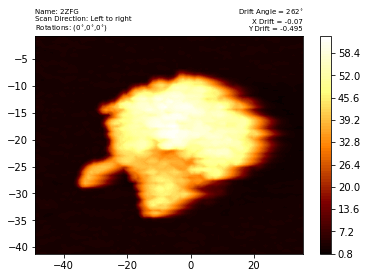

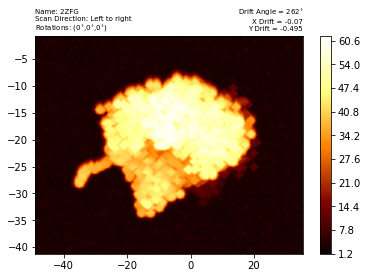

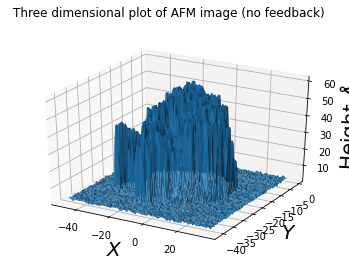

In [ ]:
%matplotlib inline

#@title #<center>AFM Simulator GUI</center>

#@markdown ###**<center>PDB or CSV upload</center>**

FileType = 'PDB' #@param ["PDB", "CSV"] {type:"string"}
ManualInput = 'No' #@param ["No", "Yes"] {type:"string"}
StructureName = '2zfg' #@param {type:"string"}

#@markdown ###**<center>Image Parameters</center>**

#@markdown Tip Radius ($\times 10^{-10}$ m / Angstroms)
r =  1#@param {type:"number"}

#@markdown Probe Gradient (Degrees / $\theta$)
theta_degrees = 2 #@param {type:"number"}

#@markdown Bin width for X and Y axis ($\times 10^{-10}$ m / Angstroms)
xstep =  1#@param {type:"number"}
ystep =  1#@param {type:"number"}

#@markdown Extension of plot boundaries ($\times 10^{-10}$ m / Angstroms)
extension =  15#@param {type:"number"}

#@markdown Rotation in each X, Y and Z axis (Degrees / $\theta$))
x_rot = 0 #@param {type:"slider", min:0,max:360,step:1}
y_rot = 0 #@param {type:"slider", min:0,max:360,step:1}
z_rot = 0 #@param {type:"slider", min:0,max:360,step:1}

#@markdown Noise Strength, Variance and Mean
noise_strength =  1#@param {type:"number"}
noise_mean =  3#@param {type:"number"}
noise_variance =  0.5#@param {type:"number"}

setpoint = 0 #@param {type:"number"} 
arb = 10 #@param {type:"number"}
KP_eff = 0.4 #@param {type:"number"}
KI = 0.6 #@param {type:"number"}
n=1 #@param {type:"number"}
grad = 1 #@param {type:"number"}
ScanRate=1 #@param {type:"number"}
DriftRate =  0.5#@param {type:"number"}
DriftAngle = 262 #@param {type:"slider", min:0,max:361,step:1}

#@markdown Scanline direction for imaging
scanline_direction = 'Left to right' #@param ["Both","Left to right","Right to left"] {type:"string"}


#@markdown ###**<center>Selecting Image Outputs</center>**
ThreeDplot = True #@param {type:"boolean"}
Feedbacked = True #@param {type:"boolean"}
ThermalDrift = True #@param {type:"boolean"}
Heatmap = True #@param {type:"boolean"}
Sharp_Color_Map = False #@param {type:"boolean"}
ImageBank = False #@param {type:"boolean"}
Colmap = 'tab20' #@param {type:"string"}
molecule_view = True #@param {type:"boolean"}
view_style = 'spacefill' #@param {type:"string"}
Simulated_Surface = False #@param {type:"boolean"}
DotPlot = False #@param {type:"boolean"}
Overlay_Plot= False #@param {type:"boolean"}
relative_contrast = 0
feedback_graph = False #@param {type:"boolean"}

#@markdown Save to google drive (email me at willcapp09@gmail.com for questions)
GoogleDrive = False #@param {type:"boolean"}

if GoogleDrive == True:
    # mount drive
    from google.colab import drive
    drive.mount('/content/gdrive')

Molecule_struc = file_loader(FileType,ManualInput,StructureName)

#Using the final function and user inputs to create final results 
AFM_sim_image_producer(Molecule_struc,r,theta_degrees,xstep,ystep, 
                        extension,x_rot,y_rot,z_rot, 
                        noise_strength,noise_mean,
                        noise_variance, setpoint,arb,
                        KP_eff,KI,n,grad, 
                        scanline_direction,
                        ScanRate,
                        DriftRate,
                        DriftAngle,
                        ThreeDplot, 
                        Feedbacked,
                        ThermalDrift,
                        Heatmap,
                        Sharp_Color_Map,
                        ImageBank, 
                        Colmap,
                        molecule_view,
                        view_style, 
                        Simulated_Surface,
                        DotPlot, 
                        Overlay_Plot, relative_contrast, 
                        feedback_graph,
                        StructureName,
                        GoogleDrive)

#@markdown ###**<center>Press Shift+Enter at Same Time To Run Code</center>** 

From Images the effect of parachuting seems to leave much more apparent artefacts. Usually dragged out and linearlly changing in depth (colormap). As opposed to the tip convolution which is much shorter, with a more drastic change in colormap

# 3.0 AI Image Bank Creator with feedback


In [ ]:
%matplotlib inline
#@title ##**<center>Image Bank Creator Prototype for Future AI Recognition - Artefacts</center>**

#@markdown A new AI GUI prototype this time to produce a range of images 
#@markdown for multiple varying parameters. Most noticeably using a range of
#@markdown different PDB files, and different directions to explore the artifacts
#@markdown left by tip convultion, parachuting, etc...

#@markdown Insert PBD ID for Molecule to Create Image Bank in form 
PDBID = '5slu' #@param {type:"string"}


#@markdown Select the Scanline Direction
direction = 'Both' #@param ["Both","Left to right","Right to left"] {type:"string"}

#@markdown Add Thermal Drift Error to Images
Drift = True #@param {type:"boolean"}

#@markdown Select Color Map for Image, Different color maps for prettier images compared to images to demonstrate artefacts with better clarity
ColorMap = 'tab20' #@param {type:"string"}

#@markdown Select Angle Step, e.g. each 30 degrees produce a new image. Use $\frac{360}{\text{Angle_step}}^3$ to find the number of photos that will be produced
Angle_step = 120 #@param {type:"slider", min:1,max:360,step:1}
img_no = int(((360)/Angle_step)**3)

#@markdown Common Image Counts for Angle Steps:

#@markdown 180 > 8 / 90 > 64 / 45 > 512 / 30 > 1728 / 15 > 15824

#@markdown Image Label Starting Number
i =  784#@param {type:"number"}

# Angles to cycle through
x_rot_range = y_rot_range = z_rot_range = np.arange(0,360,Angle_step)


Molecular_struc = file_loader('PDB','No',PDBID)

print(f'\nThe number of images being produced is:\t {img_no} \n')
for x_rot_id in tqdm_notebook(x_rot_range,leave=False):
    for y_rot_id in tqdm_notebook(y_rot_range,leave=False):
        for z_rot_id in tqdm_notebook(z_rot_range,leave=False):

            #Using the final function and user inputs to create final results 
            AFM_sim_image_producer(Molecular_struc,r=1,theta_degrees=2,xstep=1,ystep=1, 
                                    extension = 10,x_rot=x_rot_id, y_rot=y_rot_id,z_rot=z_rot_id, 
                                    noise_strength = 0, noise_mean = 2,
                                    noise_variance = 0.5, setpoint = 0 ,arb = 10 ,
                                    KP_eff = 0.4 , KI = 0.6 ,n=1, grad = 1, 
                                    scanline_direction=direction,
                                    ScanRate=1,
                                    DriftRate=0.25,
                                    DriftAngle=361,
                                    ThreeDplot = False, 
                                    Feedbacked = True,
                                    ThermalDrift = Drift,
                                    Heatmap = False,
                                    Sharp_Color_Map = False,
                                    ImageBank = True,
                                    Colmap = ColorMap, 
                                    molecule_view = False,
                                    view_style = 'spacefill',
                                    Simulated_Surface = False,
                                    DotPlot = False, 
                                    Overlay_Plot= False, relative_contrast = 0.0, 
                                    feedback_graph = False,
                                    StructureName=PDBID,
                                    GoogleDrive = False)
            
            img_file_name = i
            i += 1

            images_dir = '/content/gdrive/My Drive/AFM_Image_Bank/JPEGImages'
            plt.savefig(f"{images_dir}/00{img_file_name}.jpg", format ='jpg',transparent=True,pad_inches=0.5)
            plt.close()


https://www.mathworks.com/discovery/object-detection.html#:~:text=Object%20detection%20is%20a%20computer,learning%20to%20produce%20meaningful%20results.

https://towardsdatascience.com/train-image-recognition-ai-with-5-lines-of-code-8ed0bdd8d9ba

https://www.ibm.com/docs/sl/scdli/1.2.0?topic=dataset-images-object-detection

https://machinelearningmastery.com/how-to-train-an-object-detection-model-with-keras/

https://www.ibm.com/docs/en/scdli/1.1.0?topic=dataset-images-object-detection

https://github.com/tzutalin/labelImg

https://www.ibm.com/docs/en/app-connect/11.0.0?topic=file-creating-xml-schema-from-scratch

In [ ]:
%matplotlib inline
#@title ##**<center>Image Bank Creator Prototype for Future AI Recognition - Rotation (Obsolete)</center>**

#@markdown This GUI allows the user to create a range of images for a single
#@markdown PDB Id but with varying angles (Not entirely sure this will be
#@markdown relevant for AI recognition but it works as a foundation for future
#@markdown work). 

#@markdown Insert PBD ID for Molecule to Create Image Bank
PDBID = '' #@param {type:"string"}

#@markdown Select whether to produced images with or without feedback
Image_Type = 'Feedbacked' #@param ["Feedbacked","No Feedback"] {type:"string"}

#@markdown Select the Scanline Direction
direction = 'Right to left' #@param ["Both","Left to right","Right to left"] {type:"string"}

#@markdown Select Angle Step, e.g. each 30 degrees produce a new image. Use $\frac{360}{\text{Angle_step}}^3$ to find the number of photos that will be produced
Angle_step = 360 #@param {type:"slider", min:1,max:360,step:1}
img_no = int(((360)/Angle_step)**3)

#@markdown Common Image Counts for Angle Steps:

#@markdown 180 > 8 / 90 > 64 / 45 > 512 / 30 > 1728 / 15 > 15824

# Angles to cycle through
x_rot_range = y_rot_range = z_rot_range = np.arange(0,360,Angle_step)

if Image_Type == 'Feedbacked':
    FeedbackTrue = True
    HeatmapTrue = False

else:
    FeedbackTrue = False
    HeatmapTrue = True


Molecular_struc = file_loader('PDB','No',PDBID)

print(f'\nThe number of images being produced is:\t {img_no} \n')

for x_rot_id in tqdm_notebook(x_rot_range,leave=False):
    for y_rot_id in tqdm_notebook(y_rot_range,leave=False):
        for z_rot_id in tqdm_notebook(z_rot_range,leave=False):

            #Using the final function and user inputs to create final results 
            AFM_sim_image_producer(Molecular_struc,r=1,theta_degrees=2,xstep=1,ystep=1, 
                                    extension = 10,x_rot=x_rot_id, y_rot=y_rot_id,z_rot=z_rot_id, 
                                    noise_strength = 0, noise_mean = 2,
                                    noise_variance = 0.5, setpoint = 0 ,arb = 10 ,
                                    KP_eff = 0.4 , KI = 0.6 ,n=1, grad = 1, 
                                    scanline_direction=direction,
                                    ThreeDplot = False, 
                                    Feedbacked = FeedbackTrue,
                                    Heatmap = HeatmapTrue, 
                                    molecule_view = True,
                                    view_style = 'spacefill', 
                                    Simulated_Surface = False,
                                    DotPlot = False, 
                                    Overlay_Plot= False, relative_contrast = 0.0, 
                                    feedback_graph = False)
            
            img_file_name = 'AFM Image_' + PDBID + '_' + str(x_rot_id) + '_' + str(y_rot_id) + '_' + str(z_rot_id)

            images_dir = '/content/gdrive/My Drive/AFM_Image_Bank/' + PDBID +'_'+Image_Type + '_'+ direction
            plt.savefig(f"{images_dir}/{img_file_name}.png")
            plt.close()


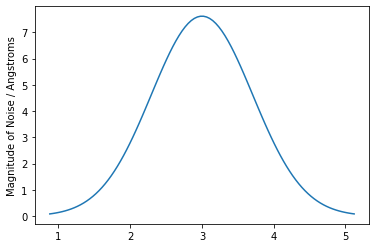

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats
import math

mu = 3
variance = 0.5
sigma = math.sqrt(variance)
x = np.linspace(mu - 3*sigma, mu + 3*sigma, 100)
plt.plot(x, 2.25*6*stats.norm.pdf(x, mu, sigma))
plt.ylabel('Magnitude of Noise / Angstroms')
plt.savefig('Dist')